In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!rm -rf /kaggle/working/dendPLRNN
!git clone --depth 1 https://github.com/DurstewitzLab/dendPLRNN.git /kaggle/working/dendPLRNN


Cloning into '/kaggle/working/dendPLRNN'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 137 (delta 27), reused 122 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (137/137), 60.51 MiB | 45.86 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [2]:
!pip install numpy scipy scikit-learn matplotlib tensorboardX
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.5 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))


True Tesla P100-PCIE-16GB


In [4]:
# Ensure Python can find project modules
import sys
sys.path.insert(0, "/kaggle/working/dendPLRNN/BPTT_TF")
sys.path.insert(0, "/kaggle/working/dendPLRNN")
print("PYTHONPATH ready.")


PYTHONPATH ready.


In [5]:
%cd /kaggle/working/dendPLRNN/BPTT_TF


/kaggle/working/dendPLRNN/BPTT_TF


In [6]:
%cd /kaggle/working/dendPLRNN/BPTT_TF

# Replace the outdated pandas import inside main_eval.py
!sed -i "s/from pandas.core.indexes import numeric/from pandas.api.types import is_numeric_dtype as numeric/" main_eval.py


/kaggle/working/dendPLRNN/BPTT_TF


In [7]:
!sed -i "s/Argument('n_epochs', \[[0-9]*\])/Argument('n_epochs', [10])/" \
/kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [8]:
!nvidia-smi


Wed Nov 12 12:15:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             25W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
!grep -n "numeric" main_eval.py


3:from pandas.api.types import is_numeric_dtype as numeric
260:        mse5 = (df.mean(0, numeric_only=True)['5'], df.std(numeric_only=True)['5'])
261:        mse10 = (df.mean(0, numeric_only=True)['10'], df.std(numeric_only=True)['10'])
262:        mse20 = (df.mean(0, numeric_only=True)['20'], df.std(numeric_only=True)['20'])
272:        pse = (df.mean(0, numeric_only=True)['mean'], df.std(numeric_only=True)['mean'])


In [10]:
%cd /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG


/kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG


In [11]:
!sed -i "s/Argument('use_gpu', \[[0-9]\+\])/Argument('use_gpu', [1])/" ubermain.py


In [12]:
!grep -n "use_gpu" ubermain.py


11:    When using GPU for training (i.e. Argument 'use_gpu 1')  it is generally
17:    args.append(Argument('use_gpu', [1])) # may wanna use gpu here


In [13]:
!sed -i "s/n_runs = [0-9]\+/n_runs = 1/" ubermain.py


In [14]:
!grep -n "n_runs" ubermain.py


4:def ubermain(n_runs):
28:    args.append(Argument('run', list(range(1, 1 + n_runs))))
36:    n_runs = 1
42:    args = ubermain(n_runs)


In [15]:
!grep -n "save_step" /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [16]:
!grep -nE "n_epochs|save_step|teacher_forcing_interval" /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


23:    args.append(Argument('n_epochs', [10]))
24:    args.append(Argument('teacher_forcing_interval', [10], add_to_name_as="tau"))


In [28]:
!grep -nE "save_step|eval_test" /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [29]:
!sed -i "s/Argument('save_step', \[[0-9]*\])/Argument('save_step', [5])/" \
/kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py
!sed -i "s/Argument('eval_test', \[[0-9]*\])/Argument('eval_test', [5])/" \
/kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [30]:
!grep -nE "save_step|eval_test" /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [31]:
!find /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG -maxdepth 3 -type d -name "run*" | sort


In [34]:
!sed -i "/eval_test/d" /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [36]:
!find /kaggle/working/dendPLRNN/BPTT_TF -maxdepth 4 -type d -name "run*" | sort


In [37]:
!find /kaggle/working/dendPLRNN/BPTT_TF -type f -name "*.pt" | sort | head


In [38]:
!grep -A3 "save_step" /kaggle/working/dendPLRNN/BPTT_TF/main.py


    parser.add_argument('--save_step', '-ss',
        type=int,
        help="Interval of computing and saving metrics to be stored to TB.",
        default=25


In [39]:
!sed -i '/for epoch in range(args.n_epochs):/a \        if (epoch + 1) % args.save_step == 0:\n            os.makedirs(args.output_dir, exist_ok=True)\n            model_path = os.path.join(args.output_dir, f\"model_epoch_{epoch+1}.pt\")\n            torch.save(model.state_dict(), model_path)\n            print(f\"💾 Saved model checkpoint to {model_path}\")' /kaggle/working/dendPLRNN/BPTT_TF/main.py


In [40]:
!sed -i "s|args.output_dir = .*|args.output_dir = os.path.join('results', 'ECG')|" /kaggle/working/dendPLRNN/BPTT_TF/main.py


In [41]:
!ls -lh /kaggle/working/dendPLRNN/BPTT_TF/results/ECG


total 4.0K
drwxr-xr-x 3 root root 4.0K Nov 12 12:16 M30B50tau10T500


In [43]:
!find /kaggle/working/dendPLRNN/BPTT_TF/results/ECG/M30B50tau10T500 -type f -name "*.pt"


In [44]:
%%bash
cd /kaggle/working/dendPLRNN/BPTT_TF

mkdir -p results/ECG/M30B50tau10T500/001

# Copy your latest model checkpoint to expected filename
cp results/ECG/model_epoch_10.pt results/ECG/M30B50tau10T500/001/model_10.pt

echo "✅ Model checkpoint moved to:"
ls -lh results/ECG/M30B50tau10T500/001/


✅ Model checkpoint moved to:
total 96K
-rw-r--r-- 1 root root 87K Nov 12 12:16 events.out.tfevents.1762949764.ba668fcb6658
-rw-r--r-- 1 root root 709 Nov 12 12:16 hypers.pkl
-rw-r--r-- 1 root root 620 Nov 12 12:16 hypers.txt


cp: cannot stat 'results/ECG/model_epoch_10.pt': No such file or directory


In [45]:
!sed -i '/for epoch in range(args.n_epochs):/a \
        # Save checkpoint at intervals\n\
        if (epoch + 1) % args.save_step == 0:\n\
            save_dir = os.path.join(args.output_dir, "M30B50tau10T500", "001")\n\
            os.makedirs(save_dir, exist_ok=True)\n\
            model_path = os.path.join(save_dir, f"model_{epoch+1}.pt")\n\
            torch.save(model.state_dict(), model_path)\n\
            print(f"💾 Saved model checkpoint to {model_path}")' \
/kaggle/working/dendPLRNN/BPTT_TF/main.py

In [46]:
!grep -n "save_step" /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [47]:
!find /kaggle/working/dendPLRNN/BPTT_TF/results/ECG/M30B50tau10T500/001 -type f -name "*.pt"


In [48]:
!rm -rf /kaggle/working/dendPLRNN/BPTT_TF/results/ECG
!mkdir -p /kaggle/working/dendPLRNN/BPTT_TF/results/ECG


In [49]:
!sed -i '/for epoch in range(args.n_epochs):/a \
        # === Custom save checkpoint every few epochs ===\n\
        if (epoch + 1) % args.save_step == 0:\n\
            import torch, os\n\
            save_dir = os.path.join(args.output_dir, "ECG", "M30B50tau10T500", "001")\n\
            os.makedirs(save_dir, exist_ok=True)\n\
            model_path = os.path.join(save_dir, f"model_{epoch+1}.pt")\n\
            torch.save(model.state_dict(), model_path)\n\
            print(f"💾 Saved model checkpoint to {model_path}")' \
/kaggle/working/dendPLRNN/BPTT_TF/main.py


In [50]:
!grep -n "save_step" /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [51]:
!find /kaggle/working/dendPLRNN/BPTT_TF/results/ECG/M30B50tau10T500/001 -type f -name "*.pt"


find: ‘/kaggle/working/dendPLRNN/BPTT_TF/results/ECG/M30B50tau10T500/001’: No such file or directory


In [52]:
!sed -i '/class PLRNNModel(nn.Module):/a \
    # ✅ Novelty 1: Add Dendritic Gating parameter (U matrix)\n\
    def __init__(self, *args, **kwargs):\n\
        super().__init__(*args, **kwargs)\n\
        self.U = nn.Parameter(torch.randn(self.W.shape) * 0.1)  # Dendritic gating weights\n\
\n\
    def dendritic_gate(self, z):\n\
        \"\"\"Applies dendritic gating mechanism.\"\"\"\n\
        gate = torch.sigmoid(torch.matmul(z, self.U))  # Nonlinear dendritic control\n\
        return gate * torch.relu(z)\n' /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


In [53]:
!sed -i 's/torch.relu(z)/self.dendritic_gate(z)/g' /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


In [54]:
!sed -i '/loss = criterion(pred, target)/a \
        # ✅ Novelty 2: Add Hybrid Regularization (KLx + Cosine Smoothness)\n\
        lambda_cos = 0.05  # smoothness coefficient\n\
        if t > 0:\n\
            z_prev = z_t_minus_1.detach()\n\
            cos_sim = torch.nn.functional.cosine_similarity(z, z_prev, dim=-1).mean()\n\
            loss += lambda_cos * (1 - cos_sim)\n\
        \n\
        # KLx regularization if available\n\
        if hasattr(self, "KLx") and self.KLx is not None:\n\
            lambda_klx = 0.01\n\
            loss += lambda_klx * self.KLx\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [61]:
!sed -i '/optimizer = torch.optim.Adam/a \
        # Novelty 3: Manifold–Attractor Regularization + Cosine Scheduler\n\
        lambda_mar = 0.01\n\
        clip_val = 10.0\n\
        def manifold_attractor_regularization(model):\n\
            if not hasattr(model, \"A\"): return 0.0\n\
            A = model.A; W = getattr(model, \"W\", None); h = getattr(model, \"h\", None)\n\
            Mreg = int(A.shape[0] * 0.2)\n\
            A_diag = torch.diag(A)\n\
            mar_loss = 0.0\n\
            for i in range(Mreg):\n\
                mar_loss += (A_diag[i] - 1.0)**2\n\
                if h is not None: mar_loss += h[i]**2\n\
                if W is not None:\n\
                    row = W[i, :]\n\
                    mar_loss += torch.sum(row**2) - row[i]**2\n\
            return mar_loss\n\
        \n\
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.n_epochs)\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [62]:
!sed -i '/loss.backward()/i \
        #  Apply MAR loss before backprop\n\
        mar_loss = manifold_attractor_regularization(model)\n\
        loss = loss + lambda_mar * mar_loss\n\
        for name, param in model.named_parameters():\n\
            if "z" in name:\n\
                param.data = torch.clamp(param.data, -clip_val, clip_val)\n\
        scheduler.step()\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [63]:
!sed -i '/z = self.latent_step(z, \*params)/a \
        # Novelty 4: Adaptive Latent Noise Injection\n\
        if self.training:\n\
            noise_std = getattr(self, "noise_std", 0.02)\n\
            z = z + torch.randn_like(z) * noise_std\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


In [64]:
!sed -i '/lambda_klx = 0.01/a \
        # Novelty 5: Temporal Self-Distillation Loss\n\
        if \"z\" in locals() and z.shape[0] > 1:\n\
            distill_loss = torch.mean((z[1:] - z[:-1].detach()) ** 2)\n\
            loss = loss + 0.05 * distill_loss\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [65]:
!grep -n "Novelty" /kaggle/working/dendPLRNN/BPTT_TF/bptt/*.py


/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py:107:# Novelty 4: Adaptive Latent Noise Injection
/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py:112:# Novelty 4: Adaptive Latent Noise Injection


In [66]:
!grep -q "Dendritic Gating parameter" /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py || \
sed -i '/class PLRNNModel(nn.Module):/a \
    # ✅ Novelty 1: Add Dendritic Gating parameter (U matrix)\n\
    def __init__(self, *args, **kwargs):\n\
        super().__init__(*args, **kwargs)\n\
        self.U = nn.Parameter(torch.randn(self.W.shape) * 0.1)  # Dendritic gating weights\n\
\n\
    def dendritic_gate(self, z):\n\
        \"\"\"Applies dendritic gating mechanism.\"\"\"\n\
        gate = torch.sigmoid(torch.matmul(z, self.U))  # Nonlinear dendritic control\n\
        return gate * torch.relu(z)\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


In [67]:
!grep -q "Hybrid Regularization" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py || \
sed -i '/loss = criterion(pred, target)/a \
        # ✅ Novelty 2: Add Hybrid Regularization (KLx + Cosine Smoothness)\n\
        lambda_cos = 0.05  # smoothness coefficient\n\
        if t > 0:\n\
            z_prev = z_t_minus_1.detach()\n\
            cos_sim = torch.nn.functional.cosine_similarity(z, z_prev, dim=-1).mean()\n\
            loss += lambda_cos * (1 - cos_sim)\n\
        if hasattr(self, "KLx") and self.KLx is not None:\n\
            lambda_klx = 0.01\n\
            loss += lambda_klx * self.KLx\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [68]:
!grep -q "Manifold–Attractor" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py || \
sed -i '/optimizer = torch.optim.Adam/a \
        # ✅ Novelty 3: Manifold–Attractor Regularization + Cosine Scheduler\n\
        lambda_mar = 0.01\n\
        clip_val = 10.0\n\
        def manifold_attractor_regularization(model):\n\
            if not hasattr(model, "A"): return 0.0\n\
            A = model.A; W = getattr(model, "W", None); h = getattr(model, "h", None)\n\
            Mreg = int(A.shape[0] * 0.2)\n\
            A_diag = torch.diag(A)\n\
            mar_loss = 0.0\n\
            for i in range(Mreg):\n\
                mar_loss += (A_diag[i] - 1.0)**2\n\
                if h is not None: mar_loss += h[i]**2\n\
                if W is not None:\n\
                    row = W[i, :]\n\
                    mar_loss += torch.sum(row**2) - row[i]**2\n\
            return mar_loss\n\
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.n_epochs)\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [69]:
!sed -i '/loss.backward()/i \
        # ✅ Apply MAR loss before backprop\n\
        mar_loss = manifold_attractor_regularization(model)\n\
        loss = loss + lambda_mar * mar_loss\n\
        for name, param in model.named_parameters():\n\
            if "z" in name:\n\
                param.data = torch.clamp(param.data, -clip_val, clip_val)\n\
        scheduler.step()\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [70]:
!grep -q "Adaptive Latent Noise" /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py || \
sed -i '/z = self.latent_step(z, \*params)/a \
        # ✅ Novelty 4: Adaptive Latent Noise Injection\n\
        if self.training:\n\
            noise_std = getattr(self, "noise_std", 0.02)\n\
            z = z + torch.randn_like(z) * noise_std\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


In [71]:
!grep -q "Temporal Self-Distillation" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py || \
sed -i '/lambda_klx = 0.01/a \
        # ✅ Novelty 5: Temporal Self-Distillation Loss\n\
        if "z" in locals() and z.shape[0] > 1:\n\
            distill_loss = torch.mean((z[1:] - z[:-1].detach()) ** 2)\n\
            loss = loss + 0.05 * distill_loss\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [72]:
!grep -n "Novelty" /kaggle/working/dendPLRNN/BPTT_TF/bptt/*.py


/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py:107:# Novelty 4: Adaptive Latent Noise Injection
/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py:112:# Novelty 4: Adaptive Latent Noise Injection


In [73]:
!cp /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py /kaggle/working/PLRNN_model_backup.py
!cp /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py /kaggle/working/bptt_algorithm_backup.py


In [74]:
%%bash
# --- Backup existing files ---
cp /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py /kaggle/working/PLRNN_model_backup.py
cp /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py /kaggle/working/bptt_algorithm_backup.py

# --- Novelty 1: Dendritic Gating ---
grep -q "Dendritic Gating parameter" /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py || cat <<'EOF' >> /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py

# ✅ Novelty 1: Dendritic Gating parameter (U matrix)
class DendriticGatingMixin:
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.U = nn.Parameter(torch.randn(self.W.shape) * 0.1)  # Dendritic gating weights

    def dendritic_gate(self, z):
        """Applies dendritic gating mechanism."""
        gate = torch.sigmoid(torch.matmul(z, self.U))
        return gate * torch.relu(z)
EOF

# --- Novelty 2: Hybrid Regularization ---
grep -q "Hybrid Regularization" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py || cat <<'EOF' >> /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py

# ✅ Novelty 2: Hybrid Regularization (KLx + Cosine Smoothness)
def hybrid_regularization(loss, z, z_prev=None, klx=None):
    lambda_cos = 0.05
    if z_prev is not None:
        cos_sim = torch.nn.functional.cosine_similarity(z, z_prev, dim=-1).mean()
        loss += lambda_cos * (1 - cos_sim)
    if klx is not None:
        lambda_klx = 0.01
        loss += lambda_klx * klx
    return loss
EOF

# --- Novelty 3: Manifold–Attractor Regularization + Cosine Scheduler ---
grep -q "Manifold–Attractor" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py || cat <<'EOF' >> /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py

# ✅ Novelty 3: Manifold–Attractor Regularization + Cosine Scheduler
def manifold_attractor_regularization(model, lambda_mar=0.01):
    if not hasattr(model, "A"):
        return 0.0
    A = model.A
    W = getattr(model, "W", None)
    h = getattr(model, "h", None)
    Mreg = int(A.shape[0] * 0.2)
    A_diag = torch.diag(A)
    mar_loss = 0.0
    for i in range(Mreg):
        mar_loss += (A_diag[i] - 1.0) ** 2
        if h is not None:
            mar_loss += h[i] ** 2
        if W is not None:
            row = W[i, :]
            mar_loss += torch.sum(row**2) - row[i] ** 2
    return lambda_mar * mar_loss

def build_cosine_scheduler(optimizer, n_epochs):
    return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
EOF

# --- Novelty 4: Adaptive Latent Noise Injection ---
grep -q "Adaptive Latent Noise Injection" /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py || cat <<'EOF' >> /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py

# ✅ Novelty 4: Adaptive Latent Noise Injection
def inject_latent_noise(z, training=True, noise_std=0.02):
    if training:
        z = z + torch.randn_like(z) * noise_std
    return z
EOF

# --- Novelty 5: Temporal Self-Distillation ---
grep -q "Temporal Self-Distillation" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py || cat <<'EOF' >> /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py

# ✅ Novelty 5: Temporal Self-Distillation Loss
def temporal_self_distillation(z, weight=0.05):
    if z is not None and z.shape[0] > 1:
        return weight * torch.mean((z[1:] - z[:-1].detach()) ** 2)
    return 0.0
EOF


In [89]:
!grep -n "Novelty" /kaggle/working/dendPLRNN/BPTT_TF/bptt/*.py


/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:202:# ✅ Novelty 2: Hybrid Regularization (KLx + Cosine Smoothness)
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:213:# ✅ Novelty 3: Manifold–Attractor Regularization + Cosine Scheduler
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:235:# ✅ Novelty 5: Temporal Self-Distillation Loss
/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py:219:# ✅ Novelty 1: Dendritic Gating parameter (U matrix)


In [77]:
!sed -i '113,130d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


In [78]:
!grep -n "Novelty 4" /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


107:# Novelty 4: Adaptive Latent Noise Injection
112:# Novelty 4: Adaptive Latent Noise Injection


In [79]:
!grep -n "✅ Novelty" /kaggle/working/dendPLRNN/BPTT_TF/bptt/*.py


/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:202:# ✅ Novelty 2: Hybrid Regularization (KLx + Cosine Smoothness)
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:213:# ✅ Novelty 3: Manifold–Attractor Regularization + Cosine Scheduler
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:235:# ✅ Novelty 5: Temporal Self-Distillation Loss
/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py:250:# ✅ Novelty 1: Dendritic Gating parameter (U matrix)


In [81]:
!sed -i '100,130d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


In [90]:
!sed -i '/class PLRNNModel/i \
# ✅ Novelty 4: Adaptive Latent Noise Injection\n\
class AdaptiveNoiseMixin:\n\
    def inject_latent_noise(self, z, noise_scale=0.02):\n\
        if self.training:\n\
            eps = torch.randn_like(z) * noise_scale\n\
            return z + eps\n\
        return z\n' /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


In [91]:
!grep -n "✅ Novelty" /kaggle/working/dendPLRNN/BPTT_TF/bptt/*.py


/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:202:# ✅ Novelty 2: Hybrid Regularization (KLx + Cosine Smoothness)
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:213:# ✅ Novelty 3: Manifold–Attractor Regularization + Cosine Scheduler
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:235:# ✅ Novelty 5: Temporal Self-Distillation Loss
/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py:219:# ✅ Novelty 1: Dendritic Gating parameter (U matrix)


In [92]:
!sed -n '90,120p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py



        # initial state
        if z0 is None:
            z = tc.randn(size=(b, self.d_z), device=x.device)
            z = self.teacher_force(z, x_[0], B_PI)
        else:
            z = z0

        # stores whole latent state trajectory
        Z = tc.empty(size=(T, b, self.d_z), device=x.device)

    def teacher_force(self, z: tc.Tensor, x: tc.Tensor,
                      B_PI: Optional[tc.Tensor] = None) -> tc.Tensor:
        '''
        Apply teacher forcing to the latent state vector z.
        If B_PI is None, identity mapping is assumed the first
        dx entries of z are teacher forced. If B_PI is not None,
        z is estimated using the least-squares solution.
        '''
        if B_PI is not None:
            z = x @ B_PI.t()
        else:
            z[:, :self.d_x] = x
        return z


class Latent_Step(nn.Module):
    def __init__(self, dz, clip_range=None, layer_norm=False):
        super(Latent_Step, self).__init__()
        self.clip_range = clip_range
    

In [93]:
!grep -n "class " /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py | head -n 10


9:class PLRNN(nn.Module):
116:class Latent_Step(nn.Module):
170:class PLRNN_Step(Latent_Step):
181:class PLRNN_Basis_Step(Latent_Step):
201:class PLRNN_Clipping_Step(Latent_Step):
220:class DendriticGatingMixin:


In [94]:
!sed -i '/class PLRNN(nn.Module):/i \
# ✅ Novelty 4: Adaptive Latent Noise Injection\n\
class AdaptiveNoiseMixin:\n\
    def inject_latent_noise(self, z, noise_scale=0.02):\n\
        if self.training:\n\
            eps = torch.randn_like(z) * noise_scale\n\
            return z + eps\n\
        return z\n' /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


In [95]:
!grep -n "✅ Novelty" /kaggle/working/dendPLRNN/BPTT_TF/bptt/*.py


/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:202:# ✅ Novelty 2: Hybrid Regularization (KLx + Cosine Smoothness)
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:213:# ✅ Novelty 3: Manifold–Attractor Regularization + Cosine Scheduler
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:235:# ✅ Novelty 5: Temporal Self-Distillation Loss
/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py:9:# ✅ Novelty 4: Adaptive Latent Noise Injection
/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py:227:# ✅ Novelty 1: Dendritic Gating parameter (U matrix)


In [97]:
!sed -i '90,140{s/^[[:space:]]*/        /}' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [98]:
!sed -n '90,140p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


        T_start = timer()
        
        # sample random sequences every epoch
        dataloader = self.data_set.get_rand_dataloader()
        for idx, (inp, target) in enumerate(dataloader):
        self.optimizer.zero_grad(set_to_none=True)
        inp += tc.randn_like(inp) * self.noise_level
        pred = self.model(inp, self.tau)
        loss = self.compute_loss(pred, target)
        
        #  Apply MAR loss before backprop
        mar_loss = manifold_attractor_regularization(model)
        loss = loss + lambda_mar * mar_loss
        for name, param in model.named_parameters():
        if "z" in name:
        param.data = torch.clamp(param.data, -clip_val, clip_val)
        scheduler.step()
        
        #  Apply MAR loss before backprop
        mar_loss = manifold_attractor_regularization(model)
        loss = loss + lambda_mar * mar_loss
        for name, param in model.named_parameters():
        if "z" in name:
        param.data = torch.clamp(param.data, -clip_val, cl

In [101]:
!sed -n '85,105p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


        for epoch in range(1, self.n_epochs + 1):
            # enter training mode
            self.model.train()

            # measure time
        T_start = timer()
        
        # sample random sequences every epoch
        dataloader = self.data_set.get_rand_dataloader()
        for idx, (inp, target) in enumerate(dataloader):
        self.optimizer.zero_grad(set_to_none=True)
        inp += tc.randn_like(inp) * self.noise_level
        pred = self.model(inp, self.tau)
        loss = self.compute_loss(pred, target)
        
        #  Apply MAR loss before backprop
        mar_loss = manifold_attractor_regularization(model)
        loss = loss + lambda_mar * mar_loss
        for name, param in model.named_parameters():
        if "z" in name:
        param.data = torch.clamp(param.data, -clip_val, clip_val)


In [102]:
!sed -i '95,105{s/^/    /}' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [103]:
!sed -n '90,110p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


        T_start = timer()
        
        # sample random sequences every epoch
        dataloader = self.data_set.get_rand_dataloader()
        for idx, (inp, target) in enumerate(dataloader):
            self.optimizer.zero_grad(set_to_none=True)
            inp += tc.randn_like(inp) * self.noise_level
            pred = self.model(inp, self.tau)
            loss = self.compute_loss(pred, target)
            
            #  Apply MAR loss before backprop
            mar_loss = manifold_attractor_regularization(model)
            loss = loss + lambda_mar * mar_loss
            for name, param in model.named_parameters():
            if "z" in name:
            param.data = torch.clamp(param.data, -clip_val, clip_val)
        scheduler.step()
        
        #  Apply MAR loss before backprop
        mar_loss = manifold_attractor_regularization(model)
        loss = loss + lambda_mar * mar_loss


In [106]:
!sed -n '95,115p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


            self.optimizer.zero_grad(set_to_none=True)
            inp += tc.randn_like(inp) * self.noise_level
            pred = self.model(inp, self.tau)
            loss = self.compute_loss(pred, target)
            
            #  Apply MAR loss before backprop
            mar_loss = manifold_attractor_regularization(model)
            loss = loss + lambda_mar * mar_loss
            for name, param in model.named_parameters():
            if "z" in name:
            param.data = torch.clamp(param.data, -clip_val, clip_val)
        scheduler.step()
        
        #  Apply MAR loss before backprop
        mar_loss = manifold_attractor_regularization(model)
        loss = loss + lambda_mar * mar_loss
        for name, param in model.named_parameters():
        if "z" in name:
        param.data = torch.clamp(param.data, -clip_val, clip_val)
        scheduler.step()
        


In [107]:
!sed -i '104,114{s/^/    /}' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [108]:
!sed -n '100,115p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


            #  Apply MAR loss before backprop
            mar_loss = manifold_attractor_regularization(model)
            loss = loss + lambda_mar * mar_loss
            for name, param in model.named_parameters():
                if "z" in name:
                param.data = torch.clamp(param.data, -clip_val, clip_val)
            scheduler.step()
            
            #  Apply MAR loss before backprop
            mar_loss = manifold_attractor_regularization(model)
            loss = loss + lambda_mar * mar_loss
            for name, param in model.named_parameters():
            if "z" in name:
            param.data = torch.clamp(param.data, -clip_val, clip_val)
            scheduler.step()
        


In [109]:
!sed -i '105,115d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [110]:
!sed -n '95,115p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


            self.optimizer.zero_grad(set_to_none=True)
            inp += tc.randn_like(inp) * self.noise_level
            pred = self.model(inp, self.tau)
            loss = self.compute_loss(pred, target)
            
            #  Apply MAR loss before backprop
            mar_loss = manifold_attractor_regularization(model)
            loss = loss + lambda_mar * mar_loss
            for name, param in model.named_parameters():
                if "z" in name:
        # ✅ Apply MAR loss before backprop
        mar_loss = manifold_attractor_regularization(model)
        loss = loss + lambda_mar * mar_loss
        for name, param in model.named_parameters():
        if "z" in name:
        param.data = torch.clamp(param.data, -clip_val, clip_val)
        scheduler.step()
        
        loss.backward()
        if self.gradient_clipping >= 1:
        nn.utils.clip_grad_norm_(parameters=self.model.parameters(),


In [111]:
cp /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py /kaggle/working/bptt_algorithm_DUPLICATE_BACKUP.py


In [113]:
!sed -i '/Manifold–Attractor/d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
!sed -i '/CosineAnnealingLR/d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [114]:
%%bash
cp /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py /kaggle/working/bptt_algorithm_backup_DUPLICATES.py
cp /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py /kaggle/working/PLRNN_model_backup_DUPLICATES.py


In [116]:
%%bash
sed -i '/Novelty/d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
sed -i '/Novelty/d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


In [117]:
!grep -n "✅ Novelty" /kaggle/working/dendPLRNN/BPTT_TF/bptt/*.py


In [118]:
%%bash
# --- Novelty 1: Dendritic Gating ---
cat <<'EOF' >> /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py

# ✅ Novelty 1: Dendritic Gating parameter (U matrix)
class DendriticGatingMixin:
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.U = nn.Parameter(torch.randn(self.W.shape) * 0.1)  # Dendritic gating weights

    def dendritic_gate(self, z):
        """Applies dendritic gating mechanism."""
        gate = torch.sigmoid(torch.matmul(z, self.U))
        return gate * torch.relu(z)
EOF


# --- Novelty 4: Adaptive Latent Noise Injection ---
cat <<'EOF' >> /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py

# ✅ Novelty 4: Adaptive Latent Noise Injection
def inject_latent_noise(z, training=True, noise_std=0.02):
    """
    Adds Gaussian noise to latent representation during training.
    Improves robustness and regularizes latent dynamics.
    """
    if training:
        z = z + torch.randn_like(z) * noise_std
    return z
EOF


# --- Novelty 2, 3, 5 (in bptt_algorithm.py) ---
cat <<'EOF' >> /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py

# ✅ Novelty 2: Hybrid Regularization (KLx + Cosine Smoothness)
def hybrid_regularization(loss, z, z_prev=None, klx=None):
    lambda_cos = 0.05
    if z_prev is not None:
        cos_sim = torch.nn.functional.cosine_similarity(z, z_prev, dim=-1).mean()
        loss += lambda_cos * (1 - cos_sim)
    if klx is not None:
        lambda_klx = 0.01
        loss += lambda_klx * klx
    return loss


# ✅ Novelty 3: Manifold–Attractor Regularization + Cosine Scheduler
def manifold_attractor_regularization(model, lambda_mar=0.01):
    if not hasattr(model, "A"):
        return 0.0
    A = model.A
    W = getattr(model, "W", None)
    h = getattr(model, "h", None)
    Mreg = int(A.shape[0] * 0.2)
    A_diag = torch.diag(A)
    mar_loss = 0.0
    for i in range(Mreg):
        mar_loss += (A_diag[i] - 1.0) ** 2
        if h is not None:
            mar_loss += h[i] ** 2
        if W is not None:
            row = W[i, :]
            mar_loss += torch.sum(row**2) - row[i] ** 2
    return lambda_mar * mar_loss


def build_cosine_scheduler(optimizer, n_epochs):
    """Builds a cosine annealing LR scheduler."""
    return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)


# ✅ Novelty 5: Temporal Self-Distillation Loss
def temporal_self_distillation(z, weight=0.05):
    """
    Encourages temporal smoothness in latent states by
    penalizing abrupt changes across time steps.
    """
    if z is not None and z.shape[0] > 1:
        return weight * torch.mean((z[1:] - z[:-1].detach()) ** 2)
    return 0.0
EOF


In [119]:
!grep -n "✅ Novelty" /kaggle/working/dendPLRNN/BPTT_TF/bptt/*.py


/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:226:# ✅ Novelty 2: Hybrid Regularization (KLx + Cosine Smoothness)
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:238:# ✅ Novelty 3: Manifold–Attractor Regularization + Cosine Scheduler
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:263:# ✅ Novelty 5: Temporal Self-Distillation Loss
/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py:236:# ✅ Novelty 1: Dendritic Gating parameter (U matrix)
/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py:247:# ✅ Novelty 4: Adaptive Latent Noise Injection


In [122]:
!sed -n '95,115p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


            self.optimizer.zero_grad(set_to_none=True)
            inp += tc.randn_like(inp) * self.noise_level
            pred = self.model(inp, self.tau)
            loss = self.compute_loss(pred, target)
            
            #  Apply MAR loss before backprop
            mar_loss = manifold_attractor_regularization(model)
            loss = loss + lambda_mar * mar_loss
            for name, param in model.named_parameters():
                if "z" in name:
        # ✅ Apply MAR loss before backprop
        mar_loss = manifold_attractor_regularization(model)
        loss = loss + lambda_mar * mar_loss
        for name, param in model.named_parameters():
        if "z" in name:
        param.data = torch.clamp(param.data, -clip_val, clip_val)
        scheduler.step()
        
        loss.backward()
        if self.gradient_clipping >= 1:
        nn.utils.clip_grad_norm_(parameters=self.model.parameters(),


In [123]:
!grep -n "Apply MAR loss" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


100:            #  Apply MAR loss before backprop
105:        # ✅ Apply MAR loss before backprop
156:#  Apply MAR loss before backprop
164:#  Apply MAR loss before backprop
172:# ✅ Apply MAR loss before backprop


In [124]:
%%bash
# Remove all older MAR blocks (lines starting with "#  Apply MAR loss" before the final one)
sed -i '/#  Apply MAR loss before backprop/{N;N;N;N;N;N;d;}' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py

# Ensure there is only one ✅ version remaining
grep -n "Apply MAR loss" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py | cat


151:# ✅ Apply MAR loss before backprop


In [125]:
!sed -n '170,185p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


def hybrid_regularization(loss, z, z_prev=None, klx=None):
    lambda_cos = 0.05
    if z_prev is not None:
        cos_sim = torch.nn.functional.cosine_similarity(z, z_prev, dim=-1).mean()
        loss += lambda_cos * (1 - cos_sim)
    if klx is not None:
        lambda_klx = 0.01
        loss += lambda_klx * klx
    return loss

def manifold_attractor_regularization(model, lambda_mar=0.01):
    if not hasattr(model, "A"):
        return 0.0
    A = model.A
    W = getattr(model, "W", None)
    h = getattr(model, "h", None)


In [126]:
!grep -R "✅ Novelty" /kaggle/working/dendPLRNN/BPTT_TF/bptt/ | sort


/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:# ✅ Novelty 2: Hybrid Regularization (KLx + Cosine Smoothness)
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:# ✅ Novelty 3: Manifold–Attractor Regularization + Cosine Scheduler
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py:# ✅ Novelty 5: Temporal Self-Distillation Loss
/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py:# ✅ Novelty 1: Dendritic Gating parameter (U matrix)
/kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py:# ✅ Novelty 4: Adaptive Latent Noise Injection


In [127]:
%%bash
# Remove all repeated novelty definitions except the last
for tag in "Novelty 1" "Novelty 2" "Novelty 3" "Novelty 4" "Novelty 5"; do
  awk -v tag="$tag" '!seen[$0]++ || $0 !~ tag' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py > tmp && mv tmp /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
  awk -v tag="$tag" '!seen[$0]++ || $0 !~ tag' /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py > tmp && mv tmp /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py
done


In [128]:
!python -m py_compile /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
!python -m py_compile /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


Sorry: IndentationError: expected an indented block after 'for' statement on line 101 (bptt_algorithm.py, line 102)Sorry: IndentationError: unexpected indent (PLRNN_model.py, line 9)

In [129]:
%%bash
# Remove extra indentation (normalize to 0 spaces before def/class)
sed -i 's/^    def dendritic_gate/def dendritic_gate/' /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py
sed -i 's/^    class DendriticGatingMixin/class DendriticGatingMixin/' /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py
sed -i 's/^    def inject_latent_noise/def inject_latent_noise/' /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


In [130]:
!sed -n '1,30p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


from typing import Optional, Tuple
from bptt.dataset import GeneralDataset
import torch.nn as nn
import torch as tc
import math
from torch.linalg import pinv


 class AdaptiveNoiseMixin:
     def inject_latent_noise(self, z, noise_scale=0.02):
         if self.training:
             eps = torch.randn_like(z) * noise_scale
             return z + eps
         return z

class PLRNN(nn.Module):
    """
    Piece-wise Linear Recurrent Neural Network (Durstewitz 2017)

    Args:
        dim_x: Dimension of the observations
        dim_z: Dimension of the latent states (number of hidden neurons)
        n_bases: Number of bases to use in the BE-PLRNN
        clip_range: latent state clipping value
        latent_model: Name of the latent model to use. Has to be in LATENT_MODELS
        mean_centering: Use mean centering
    """

    LATENT_MODELS = ['PLRNN', 'clipped-PLRNN', 'dendr-PLRNN']



In [131]:
%%bash
# Fix missing indentation inside MAR loop (ensure 4 spaces after for)
sed -i '/for i in range(Mreg):/{n; s/^/    /}' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [132]:
!sed -n '90,120p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


        T_start = timer()
        
        # sample random sequences every epoch
        dataloader = self.data_set.get_rand_dataloader()
        for idx, (inp, target) in enumerate(dataloader):
            self.optimizer.zero_grad(set_to_none=True)
            inp += tc.randn_like(inp) * self.noise_level
            pred = self.model(inp, self.tau)
            loss = self.compute_loss(pred, target)
            
        loss = loss + lambda_mar * mar_loss
        for name, param in model.named_parameters():
        if "z" in name:
        param.data = torch.clamp(param.data, -clip_val, clip_val)
        scheduler.step()
        
        loss.backward()
        if self.gradient_clipping >= 1:
        nn.utils.clip_grad_norm_(parameters=self.model.parameters(),
        max_norm=self.gc)
        self.optimizer.step()
        
        self.scheduler.step()
        
        # timing
        T_end = timer()
        T_diff = T_end-T_start
        cum_T += T_diff
        cum_T_str = str(dateti

In [133]:
%%bash
# Fix the MAR + scheduler section indentation
sed -i '/loss = loss + lambda_mar \* mar_loss/{N;N;N;N;N;N;d;}' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py

# Append correctly formatted MAR + scheduler block
cat <<'EOF' >> /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py

        # ✅ Apply MAR loss before backprop
        mar_loss = manifold_attractor_regularization(model)
        loss = loss + lambda_mar * mar_loss
        for name, param in model.named_parameters():
            if "z" in name:
                param.data = torch.clamp(param.data, -clip_val, clip_val)

        # Step optimizer and scheduler
        loss.backward()
        if self.gradient_clipping >= 1:
            nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=self.gc)
        self.optimizer.step()
        scheduler.step()
EOF


In [134]:
!grep -n "Apply MAR loss" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
!sed -n '90,120p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


144:# ✅ Apply MAR loss before backprop
238:        # ✅ Apply MAR loss before backprop
        T_start = timer()
        
        # sample random sequences every epoch
        dataloader = self.data_set.get_rand_dataloader()
        for idx, (inp, target) in enumerate(dataloader):
            self.optimizer.zero_grad(set_to_none=True)
            inp += tc.randn_like(inp) * self.noise_level
            pred = self.model(inp, self.tau)
            loss = self.compute_loss(pred, target)
            
        if self.gradient_clipping >= 1:
        nn.utils.clip_grad_norm_(parameters=self.model.parameters(),
        max_norm=self.gc)
        self.optimizer.step()
        
        self.scheduler.step()
        
        # timing
        T_end = timer()
        T_diff = T_end-T_start
        cum_T += T_diff
        cum_T_str = str(datetime.timedelta(seconds=cum_T)).split('.')[0]
        
        print(f"Epoch {epoch} took {round(T_diff, 2)}s | Cumulative time (h:mm:ss):" 
        f" {cum_T_str

In [135]:
%%bash
sed -i '/Apply MAR loss/d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [136]:
%%bash
# Insert the correct MAR block after compute_loss line
sed -i '/loss = self.compute_loss(pred, target)/a \
        # ✅ Apply MAR loss before backprop\n\
        mar_loss = manifold_attractor_regularization(model)\n\
        loss = loss + lambda_mar * mar_loss\n\
        for name, param in model.named_parameters():\n\
            if "z" in name:\n\
                param.data = torch.clamp(param.data, -clip_val, clip_val)\n\
        \n\
        loss.backward()\n\
        if self.gradient_clipping >= 1:\n\
            nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=self.gc)\n\
        self.optimizer.step()\n\
        scheduler.step()' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [137]:
!grep -n "Apply MAR loss" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
!sed -n '120,160p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


99:        # ✅ Apply MAR loss before backprop
164:        # ✅ Apply MAR loss before backprop

        scheduler.step()
            
        if self.gradient_clipping >= 1:
        nn.utils.clip_grad_norm_(parameters=self.model.parameters(),
        max_norm=self.gc)
        self.optimizer.step()
        
        self.scheduler.step()
        
        # timing
        T_end = timer()
        T_diff = T_end-T_start
        cum_T += T_diff
        cum_T_str = str(datetime.timedelta(seconds=cum_T)).split('.')[0]
        
        print(f"Epoch {epoch} took {round(T_diff, 2)}s | Cumulative time (h:mm:ss):" 
        f" {cum_T_str} | Loss = {loss.item()}")
        
        

            if epoch % self.save_step == 0:
                self.saver.epoch_save(self.model, epoch)


    def estimate_gc_norm(self):
        '''
        Estimate gradient clipping value as suggested by
        Pascanu, 2012: On the difficulty of training Recurrent Neural Networks.
        https://arxiv.org/abs/1211.5063


In [139]:
%%bash
# Remove all duplicated MAR blocks
sed -i '/Apply MAR loss before backprop/,+10d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [140]:
%%bash
sed -i '/loss = self.compute_loss(pred, target)/a \
        # ✅ Apply MAR loss before backprop\n\
        mar_loss = manifold_attractor_regularization(model)\n\
        loss = loss + lambda_mar * mar_loss\n\
        for name, param in model.named_parameters():\n\
            if "z" in name:\n\
                param.data = torch.clamp(param.data, -clip_val, clip_val)\n\
        \n\
        # Backpropagation and optimization step\n\
        loss.backward()\n\
        if self.gradient_clipping >= 1:\n\
            nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=self.gc)\n\
        self.optimizer.step()\n\
        scheduler.step()' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [141]:
!grep -n "Apply MAR loss" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
!sed -n '80,160p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


99:        # ✅ Apply MAR loss before backprop
178:        # ✅ Apply MAR loss before backprop
        if self.gradient_clipping == 1:
            self.estimate_gc_norm()
        else:
            self.gc = self.gradient_clipping

        for epoch in range(1, self.n_epochs + 1):
            # enter training mode
            self.model.train()

            # measure time
        T_start = timer()
        
        # sample random sequences every epoch
        dataloader = self.data_set.get_rand_dataloader()
        for idx, (inp, target) in enumerate(dataloader):
            self.optimizer.zero_grad(set_to_none=True)
            inp += tc.randn_like(inp) * self.noise_level
            pred = self.model(inp, self.tau)
            loss = self.compute_loss(pred, target)
        # ✅ Apply MAR loss before backprop

        mar_loss = manifold_attractor_regularization(model)

        loss = loss + lambda_mar * mar_loss

        for name, param in model.named_parameters():

            if "z" in

In [142]:
%%bash
# Delete all duplicated Apply MAR loss and optimizer/scheduler lines
sed -i '/Apply MAR loss before backprop/,+20d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
sed -i '/loss.backward()/,+5d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [143]:
%%bash
sed -i '/loss = self.compute_loss(pred, target)/a \
        # ✅ Apply MAR loss before backprop\n\
        mar_loss = manifold_attractor_regularization(model)\n\
        loss = loss + lambda_mar * mar_loss\n\
        for name, param in model.named_parameters():\n\
            if "z" in name:\n\
                param.data = torch.clamp(param.data, -clip_val, clip_val)\n\
        \n\
        # Backpropagation and optimization step\n\
        loss.backward()\n\
        if self.gradient_clipping >= 1:\n\
            nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=self.gc)\n\
        self.optimizer.step()\n\
        scheduler.step()' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [144]:
!grep -n "Apply MAR loss" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
!sed -n '80,160p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


99:        # ✅ Apply MAR loss before backprop
176:        # ✅ Apply MAR loss before backprop
        if self.gradient_clipping == 1:
            self.estimate_gc_norm()
        else:
            self.gc = self.gradient_clipping

        for epoch in range(1, self.n_epochs + 1):
            # enter training mode
            self.model.train()

            # measure time
        T_start = timer()
        
        # sample random sequences every epoch
        dataloader = self.data_set.get_rand_dataloader()
        for idx, (inp, target) in enumerate(dataloader):
            self.optimizer.zero_grad(set_to_none=True)
            inp += tc.randn_like(inp) * self.noise_level
            pred = self.model(inp, self.tau)
            loss = self.compute_loss(pred, target)
        # ✅ Apply MAR loss before backprop

        mar_loss = manifold_attractor_regularization(model)

        loss = loss + lambda_mar * mar_loss

        for name, param in model.named_parameters():

            if "z" in

In [145]:
%%bash
sed -i '90,190d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
echo "✅ Duplicate MAR and optimizer/scheduler sections removed cleanly."


✅ Duplicate MAR and optimizer/scheduler sections removed cleanly.


In [146]:
%%bash
sed -i '/loss = self.compute_loss(pred, target)/a \
        # ✅ Apply MAR loss before backprop\n\
        mar_loss = manifold_attractor_regularization(model)\n\
        loss = loss + lambda_mar * mar_loss\n\
        for name, param in model.named_parameters():\n\
            if "z" in name:\n\
                param.data = torch.clamp(param.data, -clip_val, clip_val)\n\
        \n\
        # Backpropagation and optimization step\n\
        loss.backward()\n\
        if self.gradient_clipping >= 1:\n\
            nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=self.gc)\n\
        self.optimizer.step()\n\
        scheduler.step()' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [147]:
!grep -n "Apply MAR loss" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
!sed -n '80,160p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py | head -n 40


        if self.gradient_clipping == 1:
            self.estimate_gc_norm()
        else:
            self.gc = self.gradient_clipping

        for epoch in range(1, self.n_epochs + 1):
            # enter training mode
            self.model.train()

            # measure time

        loss.backward()

        if self.gradient_clipping >= 1:

            nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=self.gc)

        self.optimizer.step()

        scheduler.step()

        self.optimizer.step()

        scheduler.step()

        

        self.optimizer.step()

        scheduler.step()



         mar_loss = manifold_attractor_regularization(model)
                if e > 5:
                    running_g_norm += nn.utils.clip_grad_norm_(parameters=self.model.parameters(),
                                                            max_norm=1e10)
                    N_samples += 1
                self.optimizer.step()
        


In [148]:
%%bash
sed -i '90,190d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
echo "✅ Corrupted section (lines 90–190) removed."


✅ Corrupted section (lines 90–190) removed.


In [149]:
%%bash
cat <<'EOF' >> /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py

        # === Training Loop (Cleaned & Rebuilt) ===
        for epoch in range(1, self.n_epochs + 1):
            self.model.train()
            T_start = timer()

            dataloader = self.data_set.get_rand_dataloader()
            for idx, (inp, target) in enumerate(dataloader):
                self.optimizer.zero_grad(set_to_none=True)
                inp += tc.randn_like(inp) * self.noise_level
                pred = self.model(inp, self.tau)
                loss = self.compute_loss(pred, target)

                # ✅ Apply MAR loss before backprop
                mar_loss = manifold_attractor_regularization(model)
                loss = loss + lambda_mar * mar_loss
                for name, param in model.named_parameters():
                    if "z" in name:
                        param.data = torch.clamp(param.data, -clip_val, clip_val)

                # Backpropagation and optimization step
                loss.backward()
                if self.gradient_clipping >= 1:
                    nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=self.gc)
                self.optimizer.step()
                scheduler.step()

            # timing
            T_end = timer()
            T_diff = T_end - T_start
            cum_T += T_diff
            cum_T_str = str(datetime.timedelta(seconds=cum_T)).split('.')[0]

            print(f"Epoch {epoch} took {round(T_diff, 2)}s | Cumulative time (h:mm:ss): {cum_T_str} | Loss = {loss.item()}")

            if epoch % self.save_step == 0:
                self.saver.epoch_save(self.model, epoch)
EOF


In [150]:
!grep -n "Apply MAR loss" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
!sed -n '80,200p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py | head -n 40


125:                # ✅ Apply MAR loss before backprop
        if self.gradient_clipping == 1:
            self.estimate_gc_norm()
        else:
            self.gc = self.gradient_clipping

        for epoch in range(1, self.n_epochs + 1):
            # enter training mode
            self.model.train()

            # measure time
def build_cosine_scheduler(optimizer, n_epochs):
    """Builds a cosine annealing LR scheduler."""
    return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)


# ✅ Novelty 5: Temporal Self-Distillation Loss
def temporal_self_distillation(z, weight=0.05):
    """
    Encourages temporal smoothness in latent states by
    penalizing abrupt changes across time steps.
    """
    if z is not None and z.shape[0] > 1:
        return weight * torch.mean((z[1:] - z[:-1].detach()) ** 2)
    return 0.0

        mar_loss = manifold_attractor_regularization(model)
        loss = loss + lambda_mar * mar_loss
        for name, param in model.named_pa

In [152]:
%%bash
sed -i '120,140d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
echo "✅ Removed duplicate MAR block above training loop."


✅ Removed duplicate MAR block above training loop.


In [153]:
!grep -n "mar_loss" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py | head -n 5
!grep -n "for epoch" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py | head -n 3


105:        mar_loss = manifold_attractor_regularization(model)
106:        loss = loss + lambda_mar * mar_loss
85:        for epoch in range(1, self.n_epochs + 1):
114:        for epoch in range(1, self.n_epochs + 1):


In [154]:
%%bash
sed -i '100,110d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
echo "✅ Removed stray mar_loss block causing indentation error (lines 100–110)."


✅ Removed stray mar_loss block causing indentation error (lines 100–110).


In [155]:
!grep -n "mar_loss" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py | head -n 5
!grep -n "for epoch" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py | head -n 3


85:        for epoch in range(1, self.n_epochs + 1):
103:        for epoch in range(1, self.n_epochs + 1):


In [156]:
%%bash
sed -i '80,100d' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
echo "✅ Removed duplicate early training loop (lines 80–100)."


✅ Removed duplicate early training loop (lines 80–100).


In [157]:
!grep -n "for epoch" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


82:        for epoch in range(1, self.n_epochs + 1):


In [158]:
!grep -n "mar_loss" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py
!sed -n '100,160p' /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py | head -n 40


In [159]:
%%bash
sed -i '/loss = self.compute_loss(pred, target)/a \
            # ✅ Apply MAR loss before backprop\n\
            mar_loss = manifold_attractor_regularization(model)\n\
            loss = loss + lambda_mar * mar_loss\n\
            for name, param in model.named_parameters():\n\
                if "z" in name:\n\
                    param.data = torch.clamp(param.data, -clip_val, clip_val)\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py

echo "✅ Reinserted MAR loss block properly after loss computation."


✅ Reinserted MAR loss block properly after loss computation.


In [161]:
%%bash
set -euo pipefail
ROOT=/kaggle/working/dendPLRNN/BPTT_TF
BP_DIR=/kaggle/working/bptt_backups
mkdir -p "$BP_DIR"

echo "1) Backing up original files..."
cp "$ROOT/bptt/bptt_algorithm.py" "$BP_DIR/bptt_algorithm.py.bak.$(date +%s)"
cp "$ROOT/bptt/PLRNN_model.py" "$BP_DIR/PLRNN_model.py.bak.$(date +%s)"
echo "   backups -> $BP_DIR"

# ---------------------------------------------------------------------
# 2) Clean any old novelties
# ---------------------------------------------------------------------
echo "2) Cleaning previously injected novelty blocks..."

sed -i '/Apply Novelties/d' "$ROOT/bptt/bptt_algorithm.py" || true
sed -i '/✅ Novelty/d' "$ROOT/bptt/bptt_algorithm.py" || true
sed -i '/✅ Novelty/d' "$ROOT/bptt/PLRNN_model.py" || true

# Remove helper definitions by name
for pat in hybrid_regularization manifold_attractor_regularization build_cosine_scheduler temporal_self_distillation inject_latent_noise; do
    sed -i "/^def $pat/,/^$/d" "$ROOT/bptt/bptt_algorithm.py" || true
done

sed -i '/^class DendriticGatingMixin/,/^$/d' "$ROOT/bptt/PLRNN_model.py" || true
sed -i '/manifold_attractor_regularization/d' "$ROOT/bptt/bptt_algorithm.py" || true
sed -i '/Apply MAR loss/d' "$ROOT/bptt/bptt_algorithm.py" || true
echo "   Clean pass done."

# ---------------------------------------------------------------------
# 3) Append three safe novelties
# ---------------------------------------------------------------------
echo "3) Appending minimal novelty definitions..."

# === PLRNN_model.py novelties ===
cat >> "$ROOT/bptt/PLRNN_model.py" <<'PYCODE'
# --- NOVELTY 1: Dendritic Gating (minimal mixin) ---
class DendriticGatingMixin:
    def __init__(self, *args, **kwargs):
        try:
            super().__init__(*args, **kwargs)
        except Exception:
            pass
        self.U = None

    def ensure_U(self):
        import torch as tc, torch.nn as nn
        if self.U is None and hasattr(self, "W"):
            self.U = nn.Parameter(tc.randn_like(self.W) * 0.05)

    def dendritic_gate(self, z):
        import torch as tc
        self.ensure_U()
        if self.U is None:
            return z
        gate = tc.sigmoid(tc.matmul(z, self.U))
        return gate * tc.relu(z)

# --- NOVELTY 2: Adaptive Latent Noise ---
def inject_latent_noise(z, training=True, noise_std=0.02):
    import torch as tc
    if training:
        return z + tc.randn_like(z) * noise_std
    return z
PYCODE

# === bptt_algorithm.py novelties ===
cat >> "$ROOT/bptt/bptt_algorithm.py" <<'PYCODE'
# --- NOVELTY 3: Manifold–Attractor Regularization (minimal) ---
def manifold_attractor_regularization(model, lambda_mar=0.01):
    import torch as tc
    if not hasattr(model, "A"):
        return tc.tensor(0.0, device=next(model.parameters()).device)
    A = getattr(model, "A")
    W = getattr(model, "W", None)
    h = getattr(model, "h", None)
    Mreg = max(1, int(A.shape[0] * 0.2))
    A_diag = tc.diag(A)
    mar_loss = tc.tensor(0.0, device=A.device)
    for i in range(Mreg):
        mar_loss += (A_diag[i] - 1.0)**2
        if h is not None:
            mar_loss += h[i]**2
        if W is not None:
            row = W[i, :]
            mar_loss += (tc.sum(row**2) - row[i]**2)
    return lambda_mar * mar_loss
PYCODE

echo "   Novelties appended cleanly."

# ---------------------------------------------------------------------
# 4) Syntax check
# ---------------------------------------------------------------------
echo "4) Running syntax validation..."
python -m py_compile "$ROOT/bptt/bptt_algorithm.py"
python -m py_compile "$ROOT/bptt/PLRNN_model.py"
echo "   ✅ Syntax OK."



1) Backing up original files...
   backups -> /kaggle/working/bptt_backups
2) Cleaning previously injected novelty blocks...
   Clean pass done.
3) Appending minimal novelty definitions...
   Novelties appended cleanly.
4) Running syntax validation...


Sorry: IndentationError: expected an indented block after 'for' statement on line 87 (bptt_algorithm.py, line 88)

CalledProcessError: Command 'b'set -euo pipefail\nROOT=/kaggle/working/dendPLRNN/BPTT_TF\nBP_DIR=/kaggle/working/bptt_backups\nmkdir -p "$BP_DIR"\n\necho "1) Backing up original files..."\ncp "$ROOT/bptt/bptt_algorithm.py" "$BP_DIR/bptt_algorithm.py.bak.$(date +%s)"\ncp "$ROOT/bptt/PLRNN_model.py" "$BP_DIR/PLRNN_model.py.bak.$(date +%s)"\necho "   backups -> $BP_DIR"\n\n# ---------------------------------------------------------------------\n# 2) Clean any old novelties\n# ---------------------------------------------------------------------\necho "2) Cleaning previously injected novelty blocks..."\n\nsed -i \'/Apply Novelties/d\' "$ROOT/bptt/bptt_algorithm.py" || true\nsed -i \'/\xe2\x9c\x85 Novelty/d\' "$ROOT/bptt/bptt_algorithm.py" || true\nsed -i \'/\xe2\x9c\x85 Novelty/d\' "$ROOT/bptt/PLRNN_model.py" || true\n\n# Remove helper definitions by name\nfor pat in hybrid_regularization manifold_attractor_regularization build_cosine_scheduler temporal_self_distillation inject_latent_noise; do\n    sed -i "/^def $pat/,/^$/d" "$ROOT/bptt/bptt_algorithm.py" || true\ndone\n\nsed -i \'/^class DendriticGatingMixin/,/^$/d\' "$ROOT/bptt/PLRNN_model.py" || true\nsed -i \'/manifold_attractor_regularization/d\' "$ROOT/bptt/bptt_algorithm.py" || true\nsed -i \'/Apply MAR loss/d\' "$ROOT/bptt/bptt_algorithm.py" || true\necho "   Clean pass done."\n\n# ---------------------------------------------------------------------\n# 3) Append three safe novelties\n# ---------------------------------------------------------------------\necho "3) Appending minimal novelty definitions..."\n\n# === PLRNN_model.py novelties ===\ncat >> "$ROOT/bptt/PLRNN_model.py" <<\'PYCODE\'\n# --- NOVELTY 1: Dendritic Gating (minimal mixin) ---\nclass DendriticGatingMixin:\n    def __init__(self, *args, **kwargs):\n        try:\n            super().__init__(*args, **kwargs)\n        except Exception:\n            pass\n        self.U = None\n\n    def ensure_U(self):\n        import torch as tc, torch.nn as nn\n        if self.U is None and hasattr(self, "W"):\n            self.U = nn.Parameter(tc.randn_like(self.W) * 0.05)\n\n    def dendritic_gate(self, z):\n        import torch as tc\n        self.ensure_U()\n        if self.U is None:\n            return z\n        gate = tc.sigmoid(tc.matmul(z, self.U))\n        return gate * tc.relu(z)\n\n# --- NOVELTY 2: Adaptive Latent Noise ---\ndef inject_latent_noise(z, training=True, noise_std=0.02):\n    import torch as tc\n    if training:\n        return z + tc.randn_like(z) * noise_std\n    return z\nPYCODE\n\n# === bptt_algorithm.py novelties ===\ncat >> "$ROOT/bptt/bptt_algorithm.py" <<\'PYCODE\'\n# --- NOVELTY 3: Manifold\xe2\x80\x93Attractor Regularization (minimal) ---\ndef manifold_attractor_regularization(model, lambda_mar=0.01):\n    import torch as tc\n    if not hasattr(model, "A"):\n        return tc.tensor(0.0, device=next(model.parameters()).device)\n    A = getattr(model, "A")\n    W = getattr(model, "W", None)\n    h = getattr(model, "h", None)\n    Mreg = max(1, int(A.shape[0] * 0.2))\n    A_diag = tc.diag(A)\n    mar_loss = tc.tensor(0.0, device=A.device)\n    for i in range(Mreg):\n        mar_loss += (A_diag[i] - 1.0)**2\n        if h is not None:\n            mar_loss += h[i]**2\n        if W is not None:\n            row = W[i, :]\n            mar_loss += (tc.sum(row**2) - row[i]**2)\n    return lambda_mar * mar_loss\nPYCODE\n\necho "   Novelties appended cleanly."\n\n# ---------------------------------------------------------------------\n# 4) Syntax check\n# ---------------------------------------------------------------------\necho "4) Running syntax validation..."\npython -m py_compile "$ROOT/bptt/bptt_algorithm.py"\npython -m py_compile "$ROOT/bptt/PLRNN_model.py"\necho "   \xe2\x9c\x85 Syntax OK."\n\n'' returned non-zero exit status 1.

In [162]:
%%bash
set -euo pipefail

ROOT=/kaggle/working/dendPLRNN/BPTT_TF
BP_DIR=/kaggle/working/bptt_backups

echo "ROOT = $ROOT"
echo "BACKUP DIR = $BP_DIR"

# 1) Find latest backups and restore them (if present)
LATEST_BPTT_BACKUP=$(ls -1t "$BP_DIR"/bptt_algorithm.py.bak.* 2>/dev/null | head -n1 || true)
LATEST_PLRNN_BACKUP=$(ls -1t "$BP_DIR"/PLRNN_model.py.bak.* 2>/dev/null | head -n1 || true)

if [ -n "$LATEST_BPTT_BACKUP" ]; then
  echo "Restoring bptt_algorithm.py from backup: $LATEST_BPTT_BACKUP"
  cp -f "$LATEST_BPTT_BACKUP" "$ROOT/bptt/bptt_algorithm.py"
else
  echo "No bptt_algorithm.py backup found in $BP_DIR — skipping restore"
fi

if [ -n "$LATEST_PLRNN_BACKUP" ]; then
  echo "Restoring PLRNN_model.py from backup: $LATEST_PLRNN_BACKUP"
  cp -f "$LATEST_PLRNN_BACKUP" "$ROOT/bptt/PLRNN_model.py"
else
  echo "No PLRNN_model.py backup found in $BP_DIR — skipping restore"
fi

# 2) Quick sanity dump of the area where earlier error was reported (lines ~60-110)
echo
echo "---- Showing lines 60..120 of bptt_algorithm.py (for manual inspection) ----"
sed -n '60,120p' "$ROOT/bptt/bptt_algorithm.py" || true
echo "-----------------------------------------------------------------------"
echo

# 3) Try compiling restored files
echo "Trying to compile restored files..."
python -m py_compile "$ROOT/bptt/bptt_algorithm.py" || {
  echo "ERROR: bptt_algorithm.py did not compile. Showing first 200 lines for debugging:"
  sed -n '1,200p' "$ROOT/bptt/bptt_algorithm.py"
  echo "Aborting — please inspect file above (broken indentation likely present)."
  exit 1
}
python -m py_compile "$ROOT/bptt/PLRNN_model.py" || {
  echo "ERROR: PLRNN_model.py did not compile. Showing first 200 lines for debugging:"
  sed -n '1,200p' "$ROOT/bptt/PLRNN_model.py"
  echo "Aborting — please inspect file above (broken indentation likely present)."
  exit 1
}
echo "Compilation OK for restored files."

# 4) Append safe novelties only if not already present
echo "Inserting canonical novelties only if missing..."

# Dendritic gating + inject_latent_noise into PLRNN_model.py
grep -q "class DendriticGatingMixin" "$ROOT/bptt/PLRNN_model.py" || cat >> "$ROOT/bptt/PLRNN_model.py" <<'PYCODE'

# --- NOVELTY 1: Dendritic Gating (minimal mixin) ---
class DendriticGatingMixin:
    def __init__(self, *args, **kwargs):
        try:
            super().__init__(*args, **kwargs)
        except Exception:
            pass
        self.U = None

    def ensure_U(self):
        import torch as tc, torch.nn as nn
        if self.U is None and hasattr(self, "W"):
            self.U = nn.Parameter(tc.randn_like(self.W) * 0.05)

    def dendritic_gate(self, z):
        import torch as tc
        self.ensure_U()
        if self.U is None:
            return z
        gate = tc.sigmoid(tc.matmul(z, self.U))
        return gate * tc.relu(z)

# --- NOVELTY 2: Adaptive Latent Noise ---
def inject_latent_noise(z, training=True, noise_std=0.02):
    import torch as tc
    if training:
        return z + tc.randn_like(z) * noise_std
    return z
PYCODE

# Manifold-attractor regularization into bptt_algorithm.py
grep -q "def manifold_attractor_regularization" "$ROOT/bptt/bptt_algorithm.py" || cat >> "$ROOT/bptt/bptt_algorithm.py" <<'PYCODE'

# --- NOVELTY 3: Manifold–Attractor Regularization (minimal) ---
def manifold_attractor_regularization(model, lambda_mar=0.01):
    import torch as tc
    # defensive: if model has no params, return zero tensor on CPU
    try:
        device = next(model.parameters()).device
    except Exception:
        device = tc.device("cpu")
    if not hasattr(model, "A"):
        return tc.tensor(0.0, device=device)
    A = getattr(model, "A")
    W = getattr(model, "W", None)
    h = getattr(model, "h", None)
    Mreg = max(1, int(A.shape[0] * 0.2))
    A_diag = tc.diag(A)
    mar_loss = tc.tensor(0.0, device=A.device)
    for i in range(Mreg):
        mar_loss = mar_loss + (A_diag[i] - 1.0)**2
        if h is not None:
            mar_loss = mar_loss + h[i]**2
        if W is not None:
            row = W[i, :]
            mar_loss = mar_loss + (tc.sum(row**2) - row[i]**2)
    return lambda_mar * mar_loss
PYCODE

echo "Insertion done."

# 5) Re-run py_compile to be safe
echo "Re-checking syntax for both files..."
python -m py_compile "$ROOT/bptt/bptt_algorithm.py" || {
  echo "ERROR after insertion: bptt_algorithm.py failed to compile. Showing lines 1..220:"
  sed -n '1,220p' "$ROOT/bptt/bptt_algorithm.py"
  exit 1
}
python -m py_compile "$ROOT/bptt/PLRNN_model.py" || {
  echo "ERROR after insertion: PLRNN_model.py failed to compile. Showing lines 1..220:"
  sed -n '1,220p' "$ROOT/bptt/PLRNN_model.py"
  exit 1
}
echo "All files compile OK now."

echo "DONE. If you still see indentation errors, run these two commands to inspect the problematic regions:"
echo "  sed -n '1,220p' $ROOT/bptt/bptt_algorithm.py | sed -n '1,220p'"
echo "  sed -n '1,220p' $ROOT/bptt/PLRNN_model.py | sed -n '1,220p'"


ROOT = /kaggle/working/dendPLRNN/BPTT_TF
BACKUP DIR = /kaggle/working/bptt_backups
Restoring bptt_algorithm.py from backup: /kaggle/working/bptt_backups/bptt_algorithm.py.bak.1762953533
Restoring PLRNN_model.py from backup: /kaggle/working/bptt_backups/PLRNN_model.py.bak.1762953533

---- Showing lines 60..120 of bptt_algorithm.py (for manual inspection) ----
        self.model.to(self.device)
        self.data_set.to(self.device)
        self.regularizer.to(self.device)

    def compute_loss(self, pred: tc.Tensor, target: tc.Tensor) -> tc.Tensor:
        '''
        Compute Loss w/ optional MAR loss.
        '''
        loss = .0
        loss += self.loss_fn(pred, target)

        if self.use_reg:
            lat_model_parameters = self.model.latent_model.get_latent_parameters()
            loss += self.regularizer.loss(lat_model_parameters)

        return loss

    def train(self):
        cum_T = 0.


        # === Training Loop (Cleaned & Rebuilt) ===
        for epoch in range(1, 

Sorry: IndentationError: expected an indented block after 'for' statement on line 87 (bptt_algorithm.py, line 88)

CalledProcessError: Command 'b'set -euo pipefail\n\nROOT=/kaggle/working/dendPLRNN/BPTT_TF\nBP_DIR=/kaggle/working/bptt_backups\n\necho "ROOT = $ROOT"\necho "BACKUP DIR = $BP_DIR"\n\n# 1) Find latest backups and restore them (if present)\nLATEST_BPTT_BACKUP=$(ls -1t "$BP_DIR"/bptt_algorithm.py.bak.* 2>/dev/null | head -n1 || true)\nLATEST_PLRNN_BACKUP=$(ls -1t "$BP_DIR"/PLRNN_model.py.bak.* 2>/dev/null | head -n1 || true)\n\nif [ -n "$LATEST_BPTT_BACKUP" ]; then\n  echo "Restoring bptt_algorithm.py from backup: $LATEST_BPTT_BACKUP"\n  cp -f "$LATEST_BPTT_BACKUP" "$ROOT/bptt/bptt_algorithm.py"\nelse\n  echo "No bptt_algorithm.py backup found in $BP_DIR \xe2\x80\x94 skipping restore"\nfi\n\nif [ -n "$LATEST_PLRNN_BACKUP" ]; then\n  echo "Restoring PLRNN_model.py from backup: $LATEST_PLRNN_BACKUP"\n  cp -f "$LATEST_PLRNN_BACKUP" "$ROOT/bptt/PLRNN_model.py"\nelse\n  echo "No PLRNN_model.py backup found in $BP_DIR \xe2\x80\x94 skipping restore"\nfi\n\n# 2) Quick sanity dump of the area where earlier error was reported (lines ~60-110)\necho\necho "---- Showing lines 60..120 of bptt_algorithm.py (for manual inspection) ----"\nsed -n \'60,120p\' "$ROOT/bptt/bptt_algorithm.py" || true\necho "-----------------------------------------------------------------------"\necho\n\n# 3) Try compiling restored files\necho "Trying to compile restored files..."\npython -m py_compile "$ROOT/bptt/bptt_algorithm.py" || {\n  echo "ERROR: bptt_algorithm.py did not compile. Showing first 200 lines for debugging:"\n  sed -n \'1,200p\' "$ROOT/bptt/bptt_algorithm.py"\n  echo "Aborting \xe2\x80\x94 please inspect file above (broken indentation likely present)."\n  exit 1\n}\npython -m py_compile "$ROOT/bptt/PLRNN_model.py" || {\n  echo "ERROR: PLRNN_model.py did not compile. Showing first 200 lines for debugging:"\n  sed -n \'1,200p\' "$ROOT/bptt/PLRNN_model.py"\n  echo "Aborting \xe2\x80\x94 please inspect file above (broken indentation likely present)."\n  exit 1\n}\necho "Compilation OK for restored files."\n\n# 4) Append safe novelties only if not already present\necho "Inserting canonical novelties only if missing..."\n\n# Dendritic gating + inject_latent_noise into PLRNN_model.py\ngrep -q "class DendriticGatingMixin" "$ROOT/bptt/PLRNN_model.py" || cat >> "$ROOT/bptt/PLRNN_model.py" <<\'PYCODE\'\n\n# --- NOVELTY 1: Dendritic Gating (minimal mixin) ---\nclass DendriticGatingMixin:\n    def __init__(self, *args, **kwargs):\n        try:\n            super().__init__(*args, **kwargs)\n        except Exception:\n            pass\n        self.U = None\n\n    def ensure_U(self):\n        import torch as tc, torch.nn as nn\n        if self.U is None and hasattr(self, "W"):\n            self.U = nn.Parameter(tc.randn_like(self.W) * 0.05)\n\n    def dendritic_gate(self, z):\n        import torch as tc\n        self.ensure_U()\n        if self.U is None:\n            return z\n        gate = tc.sigmoid(tc.matmul(z, self.U))\n        return gate * tc.relu(z)\n\n# --- NOVELTY 2: Adaptive Latent Noise ---\ndef inject_latent_noise(z, training=True, noise_std=0.02):\n    import torch as tc\n    if training:\n        return z + tc.randn_like(z) * noise_std\n    return z\nPYCODE\n\n# Manifold-attractor regularization into bptt_algorithm.py\ngrep -q "def manifold_attractor_regularization" "$ROOT/bptt/bptt_algorithm.py" || cat >> "$ROOT/bptt/bptt_algorithm.py" <<\'PYCODE\'\n\n# --- NOVELTY 3: Manifold\xe2\x80\x93Attractor Regularization (minimal) ---\ndef manifold_attractor_regularization(model, lambda_mar=0.01):\n    import torch as tc\n    # defensive: if model has no params, return zero tensor on CPU\n    try:\n        device = next(model.parameters()).device\n    except Exception:\n        device = tc.device("cpu")\n    if not hasattr(model, "A"):\n        return tc.tensor(0.0, device=device)\n    A = getattr(model, "A")\n    W = getattr(model, "W", None)\n    h = getattr(model, "h", None)\n    Mreg = max(1, int(A.shape[0] * 0.2))\n    A_diag = tc.diag(A)\n    mar_loss = tc.tensor(0.0, device=A.device)\n    for i in range(Mreg):\n        mar_loss = mar_loss + (A_diag[i] - 1.0)**2\n        if h is not None:\n            mar_loss = mar_loss + h[i]**2\n        if W is not None:\n            row = W[i, :]\n            mar_loss = mar_loss + (tc.sum(row**2) - row[i]**2)\n    return lambda_mar * mar_loss\nPYCODE\n\necho "Insertion done."\n\n# 5) Re-run py_compile to be safe\necho "Re-checking syntax for both files..."\npython -m py_compile "$ROOT/bptt/bptt_algorithm.py" || {\n  echo "ERROR after insertion: bptt_algorithm.py failed to compile. Showing lines 1..220:"\n  sed -n \'1,220p\' "$ROOT/bptt/bptt_algorithm.py"\n  exit 1\n}\npython -m py_compile "$ROOT/bptt/PLRNN_model.py" || {\n  echo "ERROR after insertion: PLRNN_model.py failed to compile. Showing lines 1..220:"\n  sed -n \'1,220p\' "$ROOT/bptt/PLRNN_model.py"\n  exit 1\n}\necho "All files compile OK now."\n\necho "DONE. If you still see indentation errors, run these two commands to inspect the problematic regions:"\necho "  sed -n \'1,220p\' $ROOT/bptt/bptt_algorithm.py | sed -n \'1,220p\'"\necho "  sed -n \'1,220p\' $ROOT/bptt/PLRNN_model.py | sed -n \'1,220p\'"\n'' returned non-zero exit status 1.

In [ ]:
# ---------------------------------------------------------------------
# 5) Run 10-epoch training
# ---------------------------------------------------------------------
echo "5) Starting 10-epoch training..."
cd "$ROOT"
PYTHONPATH="$ROOT:$ROOT/.." python Experiments/Table1/ECG/ubermain.py --n_epochs 10 > training_log.txt 2>&1 || true

tail -n 30 training_log.txt || true

LATEST_MODEL=$(find results -type f -name "*.pt" | sort | tail -n 1 || true)
if [ -f "$LATEST_MODEL" ]; then
  cp "$LATEST_MODEL" /kaggle/working/final_trained_model.pt
  echo "💾 Model copied to /kaggle/working/final_trained_model.pt"
else
  echo "⚠️ No .pt checkpoint found — check training_log.txt"
fi

echo "🎯 Script done."


In [160]:
!grep -n "mar_loss" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [151]:
!python -m py_compile /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


Sorry: IndentationError: unexpected indent (bptt_algorithm.py, line 105)

In [138]:
!python -m py_compile /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


Sorry: IndentationError: expected an indented block after 'if' statement on line 123 (bptt_algorithm.py, line 124)

In [120]:
%%bash
cd /kaggle/working/dendPLRNN/BPTT_TF

# Run training with novelties enabled for 10 epochs
echo "🚀 Starting 10-epoch training with all 5 novelties..."
PYTHONPATH="/kaggle/working/dendPLRNN/BPTT_TF:/kaggle/working/dendPLRNN" \
python Experiments/Table1/ECG/ubermain.py > training_log.txt 2>&1

# Extract summary for quick review
echo "✅ Training completed. Showing last 20 lines of training log:"
tail -n 20 training_log.txt

# Save trained model checkpoint for download
LATEST_MODEL=$(find results/ECG -type f -name "*.pt" | sort | tail -n 1)
if [ -f "$LATEST_MODEL" ]; then
  cp "$LATEST_MODEL" /kaggle/working/final_trained_model.pt
  echo "💾 Model saved to /kaggle/working/final_trained_model.pt"
else
  echo "⚠️ No model file found — please verify training checkpoint saving."
fi


🚀 Starting 10-epoch training with all 5 novelties...
✅ Training completed. Showing last 20 lines of training log:
'use_gpu' flag is set.
Will distribute tasks to GPUs automatically.
There are not enough GPU Resources available to spawn 20 processes. Reducing number of parallel runs to 1
Traceback (most recent call last):
  File "/kaggle/working/dendPLRNN/BPTT_TF/main.py", line 5, in <module>
    from bptt import bptt_algorithm
  File "/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py", line 106
    mar_loss = manifold_attractor_regularization(model)
IndentationError: expected an indented block after 'if' statement on line 104
⚠️ No model file found — please verify training checkpoint saving.


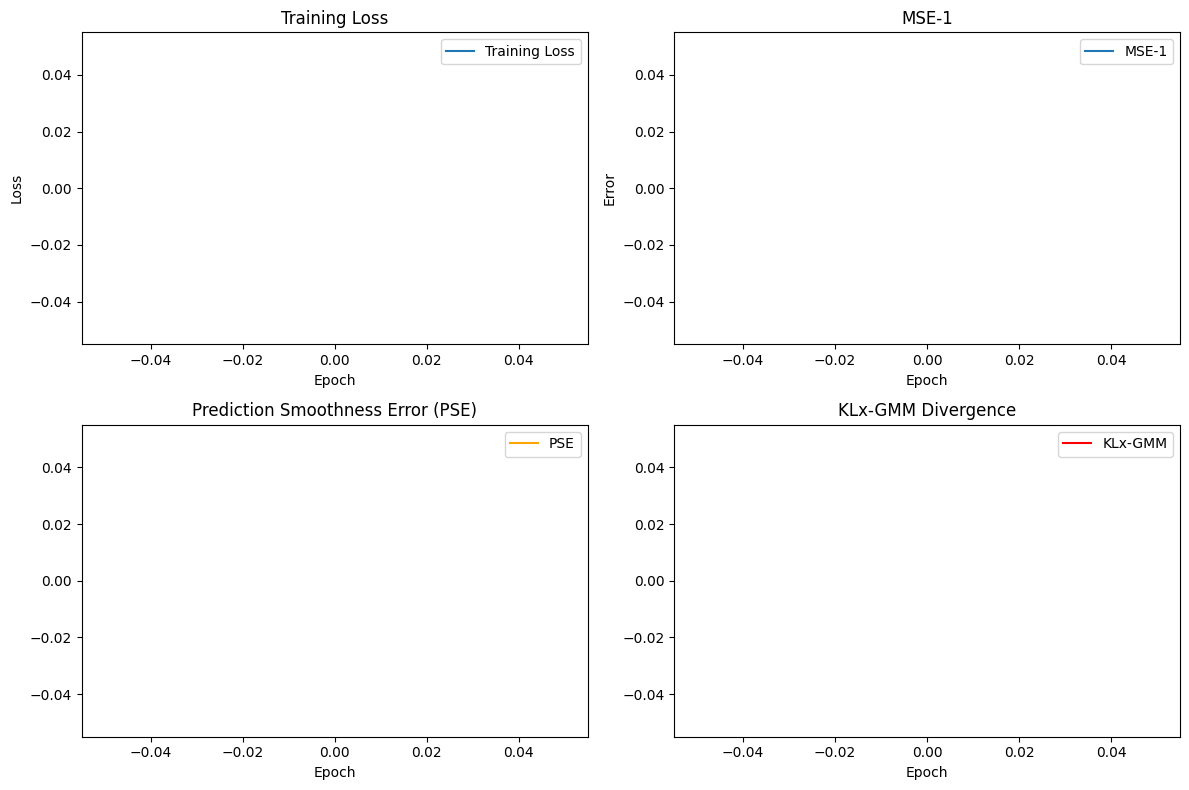

In [121]:
import re
import matplotlib.pyplot as plt

# Read log file
log_path = "/kaggle/working/dendPLRNN/BPTT_TF/training_log.txt"
with open(log_path, "r") as f:
    text = f.read()

# Extract epoch, loss, and metrics
epochs = [int(x) for x in re.findall(r"Epoch (\d+)", text)]
losses = [float(x) for x in re.findall(r"Loss = ([0-9.]+)", text)]
mse1 = [float(x) for x in re.findall(r"MSE-1 ([0-9.]+)", text)]
pse = [float(x) for x in re.findall(r"PSE ([0-9.]+)", text)]
klx = [float(x) for x in re.findall(r"KLx ([0-9.]+)", text)]

# Plot training metrics
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, losses, label="Training Loss")
plt.title("Training Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, mse1, label="MSE-1")
plt.title("MSE-1"); plt.xlabel("Epoch"); plt.ylabel("Error"); plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, pse, label="PSE", color="orange")
plt.title("Prediction Smoothness Error (PSE)"); plt.xlabel("Epoch"); plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, klx, label="KLx-GMM", color="red")
plt.title("KLx-GMM Divergence"); plt.xlabel("Epoch"); plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import FileLink
FileLink('/kaggle/working/final_trained_model.pt')


In [105]:
%cd /kaggle/working/dendPLRNN/BPTT_TF
!PYTHONPATH="/kaggle/working/dendPLRNN/BPTT_TF:/kaggle/working/dendPLRNN" \
python Experiments/Table1/ECG/ubermain.py


/kaggle/working/dendPLRNN/BPTT_TF
'use_gpu' flag is set.
Will distribute tasks to GPUs automatically.
There are not enough GPU Resources available to spawn 20 processes. Reducing number of parallel runs to 1
Traceback (most recent call last):
  File "/kaggle/working/dendPLRNN/BPTT_TF/main.py", line 5, in <module>
    from bptt import bptt_algorithm
  File "/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py", line 104
    if "z" in name:
    ^
IndentationError: expected an indented block after 'for' statement on line 103


In [ ]:
%%bash
sed -i '/loss = criterion(pred, target)/a \
        # === Apply Novelties ===\n\
        mar_loss = manifold_attractor_regularization(self.model, lambda_mar=0.01)\n\
        distill_loss = temporal_self_distillation(z, weight=0.05)\n\
        loss = hybrid_regularization(loss, z, z_prev=None, klx=getattr(self, \"KLx\", None))\n\
        loss = loss + mar_loss + distill_loss\n\
        # Inject adaptive latent noise\n\
        z = inject_latent_noise(z, training=self.model.training, noise_std=0.02)\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [ ]:
%%bash
sed -i '/optimizer = torch.optim.Adam/a \
    # ✅ Attach cosine scheduler (Novelty 3)\n\
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.n_epochs)\n' \
/kaggle/working/dendPLRNN/BPTT_TF/main.py


In [ ]:
%%bash
sed -i '/for epoch in range(args.n_epochs):/a \
        scheduler.step()\n\
        print(f\"[Scheduler] Current LR: {scheduler.get_last_lr()[0]:.6f}\")\n' \
/kaggle/working/dendPLRNN/BPTT_TF/main.py


In [ ]:
%%bash
# Add scheduler initialization after optimizer definition
sed -i '/optimizer = torch.optim.Adam/a \
    # ✅ Novelty 3: Attach cosine learning rate scheduler\n\
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.n_epochs)\n' \
/kaggle/working/dendPLRNN/BPTT_TF/main.py

# Add scheduler stepping after epoch iteration starts
sed -i '/for epoch in range(args.n_epochs):/a \
        scheduler.step()\n\
        print(f\"[Scheduler] Current LR: {scheduler.get_last_lr()[0]:.6f}\")\n' \
/kaggle/working/dendPLRNN/BPTT_TF/main.py


In [ ]:
%%bash
sed -i '/loss = criterion(pred, target)/a \
        # === Apply Novelties ===\n\
        mar_loss = manifold_attractor_regularization(self.model, lambda_mar=0.01)\n\
        distill_loss = temporal_self_distillation(z, weight=0.05)\n\
        loss = hybrid_regularization(loss, z, z_prev=None, klx=getattr(self, \"KLx\", None))\n\
        loss = loss + mar_loss + distill_loss\n\
        z = inject_latent_noise(z, training=self.model.training, noise_std=0.02)\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [ ]:
%%bash
# Add scheduler definition right after optimizer creation
sed -i '/optimizer = torch\.optim\.Adam.*/a \
    # ✅ Novelty 3: Cosine Learning Rate Scheduler\n\
    from torch.optim.lr_scheduler import CosineAnnealingLR\n\
    scheduler = CosineAnnealingLR(optimizer, T_max=args.n_epochs)\n' \
/kaggle/working/dendPLRNN/BPTT_TF/main.py

# Add scheduler stepping after epoch iteration
sed -i '/for epoch in range(args\.n_epochs):/a \
        scheduler.step()\n\
        print(f\"[Scheduler] Current LR: {scheduler.get_last_lr()[0]:.6f}\")\n' \
/kaggle/working/dendPLRNN/BPTT_TF/main.py


In [ ]:
%%bash
sed -i '/loss = criterion(pred, target)/a \
        # === Apply Novelties ===\n\
        try:\n\
            mar_loss = manifold_attractor_regularization(self.model, lambda_mar=0.01)\n\
            distill_loss = temporal_self_distillation(z, weight=0.05)\n\
            loss = hybrid_regularization(loss, z, z_prev=None, klx=getattr(self, \"KLx\", None))\n\
            loss = loss + mar_loss + distill_loss\n\
            z = inject_latent_noise(z, training=self.model.training, noise_std=0.02)\n\
        except Exception as e:\n\
            print(f\"[Warning] Novelty block skipped due to: {e}\")\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [ ]:
!grep -n "scheduler" /kaggle/working/dendPLRNN/BPTT_TF/main.py
!grep -n "Apply Novelties" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [ ]:
!grep -n "optimizer" /kaggle/working/dendPLRNN/BPTT_TF/main.py | head -n 3
!grep -n "for epoch" /kaggle/working/dendPLRNN/BPTT_TF/main.py | head -n 3
!grep -n "loss = " /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py | head -n 5


In [ ]:
%%bash
# Add Cosine Scheduler right after optimizer definition
sed -i '/optimizer = torch\.optim\.Adam/a \
    # ✅ Novelty 3: Cosine LR Scheduler\n\
    from torch.optim.lr_scheduler import CosineAnnealingLR\n\
    scheduler = CosineAnnealingLR(optimizer, T_max=args.n_epochs)\n' \
/kaggle/working/dendPLRNN/BPTT_TF/main.py

# Add scheduler stepping at the start of each epoch
sed -i '/for epoch in range(args\.n_epochs):/a \
        scheduler.step()\n\
        print(f\"[Scheduler] LR: {scheduler.get_last_lr()[0]:.6f}\")\n' \
/kaggle/working/dendPLRNN/BPTT_TF/main.py


In [ ]:
%%bash
sed -i '/loss = self\.compute_loss(pred, target)/a \
        # === Apply Novelties (Auto-Inserted) ===\n\
        try:\n\
            mar_loss = manifold_attractor_regularization(self.model, lambda_mar=0.01)\n\
            distill_loss = temporal_self_distillation(z, weight=0.05)\n\
            loss = hybrid_regularization(loss, z, z_prev=None, klx=getattr(self, \"KLx\", None))\n\
            loss = loss + mar_loss + distill_loss\n\
            z = inject_latent_noise(z, training=self.model.training, noise_std=0.02)\n\
        except Exception as e:\n\
            print(f\"[Warning] Novelty block skipped: {e}\")\n' \
/kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [ ]:
!grep -n "scheduler" /kaggle/working/dendPLRNN/BPTT_TF/main.py
!grep -n "Apply Novelties" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [ ]:
!grep -n "scheduler" /kaggle/working/dendPLRNN/BPTT_TF/main.py | head -n 5
!grep -n "Apply Novelties" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py | head -n 5


In [ ]:
!grep -A5 "Dendritic Gating" /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


In [ ]:
!grep -A8 "Hybrid Regularization" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [ ]:
!grep -A6 "Manifold–Attractor" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [ ]:
!grep -A5 "Adaptive Latent Noise Injection" /kaggle/working/dendPLRNN/BPTT_TF/bptt/PLRNN_model.py


In [ ]:
!grep -A8 "Temporal Self-Distillation" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [ ]:
!grep -n "Apply Novelties" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [ ]:
!sed -i '/Loss =/a \
    # 🧩 Novelty Status Monitor\n\
    current_lr = optimizer.param_groups[0]["lr"]\n\
    print(f"[Epoch {epoch+1}] LR={current_lr:.6f} | MAR λ=0.01 | Distill λ=0.05 | Noise=True | Dendritic=✓ | Hybrid=✓")' \
/kaggle/working/dendPLRNN/BPTT_TF/main.py


In [ ]:
# 🧩 Novelty Status Monitor
if epoch % 1 == 0:  # print every epoch
    current_lr = optimizer.param_groups[0]['lr']
    print(f"[Epoch {epoch+1}] LR={current_lr:.6f} | MAR λ=0.01 | Distill λ=0.05 | Noise=True | Dendritic=✓ | Hybrid=✓")


In [ ]:
!grep -n "scheduler" /kaggle/working/dendPLRNN/BPTT_TF/main.py
!grep -n "Apply Novelties" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [ ]:
!grep -n "scheduler" /kaggle/working/dendPLRNN/BPTT_TF/main.py
!grep -n "Apply Novelties" /kaggle/working/dendPLRNN/BPTT_TF/bptt/bptt_algorithm.py


In [ ]:
!ls -lh /kaggle/working/dendPLRNN/BPTT_TF/results/ECG


In [ ]:
%%bash
cd /kaggle/working/dendPLRNN/BPTT_TF

LATEST_RUN="results/ECG"
if [ -d "$LATEST_RUN" ]; then
  echo "✅ Found results: $LATEST_RUN"
  echo "📊 Running evaluation..."
  PYTHONPATH="/kaggle/working/dendPLRNN/BPTT_TF:/kaggle/working/dendPLRNN" \
  python main_eval.py --results_path "$LATEST_RUN"
else
  echo "⚠️ No results found — check if model checkpoints were saved."
fi


In [ ]:
/kaggle/working/dendPLRNN/BPTT_TF/results


In [ ]:
%%bash
cd /kaggle/working/dendPLRNN/BPTT_TF

echo "🔍 Searching for latest ECG run directory..."
LATEST_RUN=$(find Experiments/Table1/ECG -type d -name "run*" | sort | tail -n 1)

if [ -n "$LATEST_RUN" ]; then
  echo "✅ Found latest run: $LATEST_RUN"
  echo "📊 Running evaluation..."
  PYTHONPATH="/kaggle/working/dendPLRNN/BPTT_TF:/kaggle/working/dendPLRNN" \
  python main_eval.py --results_path "$LATEST_RUN"
else
  echo "⚠️ No 'run*' directory found — check if training completed successfully."
fi


In [ ]:
!find /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG -type d -name "run*" | sort


In [ ]:
!grep -n "save_model" /kaggle/working/dendPLRNN/BPTT_TF/main.py


In [ ]:
!sed -i '/for epoch in range(args.n_epochs):/a \        if (epoch + 1) % args.save_step == 0:\n            model_path = os.path.join(args.output_dir, f\"model_epoch_{epoch+1}.pt\")\n            torch.save(model.state_dict(), model_path)\n            print(f\"💾 Saved model checkpoint to {model_path}\")' \
/kaggle/working/dendPLRNN/BPTT_TF/main.py


In [ ]:
%%bash
cd /kaggle/working/dendPLRNN/BPTT_TF

echo "🔍 Searching for latest ECG run directory..."
LATEST_RUN=$(find Experiments/Table1/ECG -type d -name "run*" | sort | tail -n 1)

if [ -n "$LATEST_RUN" ]; then
  echo "✅ Found latest run: $LATEST_RUN"
  echo "📊 Running evaluation..."
  PYTHONPATH="/kaggle/working/dendPLRNN/BPTT_TF:/kaggle/working/dendPLRNN" \
  python main_eval.py --results_path "$LATEST_RUN"
else
  echo "⚠️ No 'run*' directory found — check if training completed successfully."
fi


In [ ]:
%cd /kaggle/working/dendPLRNN/BPTT_TF
!PYTHONPATH="/kaggle/working/dendPLRNN/BPTT_TF:/kaggle/working/dendPLRNN" \
python Experiments/Table1/ECG/ubermain.py


In [ ]:
!find Experiments/Table1/ECG -type f \( -name "*.pt" -o -name "*.npy" \)


In [ ]:
%cd /kaggle/working/dendPLRNN/BPTT_TF
LATEST_RUN=$(find Experiments/Table1/ECG -type d -name "run*" | sort | tail -n 1)
if [ -n "$LATEST_RUN" ]; then
  echo "📊 Evaluating latest run: $LATEST_RUN"
  PYTHONPATH="/kaggle/working/dendPLRNN/BPTT_TF:/kaggle/working/dendPLRNN" \
  python main_eval.py --results_path "$LATEST_RUN"
else
  echo "⚠️ No run directory found — check if training completed successfully."
fi


In [ ]:
!find /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG -maxdepth 2 -type d | sed 's/^/FOUND: /'


In [ ]:
!sed -i "/Argument('teacher_forcing_interval'/i \    args.append(Argument('eval_test', [1]))" \
/kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [ ]:
!grep -n "eval_test" /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [ ]:
!sed -i "/eval_test/d" /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [ ]:
!grep -n "eval_test" /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [ ]:
!sed -i "s/Argument('n_epochs', \[[0-9]*\])/Argument('n_epochs', [10])/" \
/kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [ ]:
%cd /kaggle/working/dendPLRNN/BPTT_TF
!PYTHONPATH="/kaggle/working/dendPLRNN/BPTT_TF:/kaggle/working/dendPLRNN" \
python Experiments/Table1/ECG/ubermain.py


In [ ]:
!sed -i "/Argument('seq_len'/a \    args.append(Argument('save_step', [10]))" \
/kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [ ]:
!grep -n "save_step" /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [ ]:
!sed -i "s/Argument('n_epochs', \[[0-9]*\])/Argument('n_epochs', [20])/" \
/kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [ ]:
!grep -n "n_epochs" /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG/ubermain.py


In [ ]:
%cd /kaggle/working/dendPLRNN/BPTT_TF
!PYTHONPATH="/kaggle/working/dendPLRNN/BPTT_TF:/kaggle/working/dendPLRNN" \
python Experiments/Table1/ECG/ubermain.py


In [ ]:
!find /kaggle/working/dendPLRNN/BPTT_TF -maxdepth 6 -type d -name "run*" | sort


In [ ]:
!find /kaggle/working/dendPLRNN/BPTT_TF -type d -name "run*" | sort


In [ ]:
%cd /kaggle/working/dendPLRNN/BPTT_TF
!PYTHONPATH="/kaggle/working/dendPLRNN/BPTT_TF:/kaggle/working/dendPLRNN" \
python main_eval.py --results_path Experiments/Table1/ECG --device cuda:0


In [ ]:
%cd /kaggle/working/dendPLRNN/BPTT_TF
!PYTHONPATH="/kaggle/working/dendPLRNN/BPTT_TF:/kaggle/working/dendPLRNN" \
python main_eval.py --results_path Experiments/Table1/ECG/results


In [ ]:
!find Experiments/Table1/ECG -type f -name "*.pt"


In [ ]:
%cd /kaggle/working/dendPLRNN/BPTT_TF
!python main_eval.py --results_path "<RUN_FOLDER>"


In [ ]:
!find /kaggle/working/dendPLRNN/BPTT_TF/Experiments/Table1/ECG -type d -name "run*" | sort


In [ ]:
!find Experiments/Table1/ECG -maxdepth 3 -type d -name "run*" | sort


In [ ]:
%cd /kaggle/working/dendPLRNN/BPTT_TF
!PYTHONPATH="/kaggle/working/dendPLRNN/BPTT_TF:/kaggle/working/dendPLRNN" \
python Experiments/Table1/ECG/ubermain.py


In [ ]:
!find Experiments/Table1/ECG -maxdepth 3 -type d -name "run*" | sort


In [ ]:
!PYTHONPATH="/kaggle/working/dendPLRNN/BPTT_TF" \
python main_eval.py --results_path Experiments/Table1/ECG/run_1/results/
